# Cell 1 - Import & path

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import umap
import hdbscan

DATA_PROCESSED_DIR = os.path.join("..", "data", "processed")
print("DATA_PROCESSED_DIR:", DATA_PROCESSED_DIR)


DATA_PROCESSED_DIR: ../data/processed


In [2]:
data_path = os.path.join(DATA_PROCESSED_DIR, "spotify_dataset_clean.csv")  # cambia nome se diverso
df = pd.read_csv(data_path)

print("Shape df:", df.shape)
df.head()

Shape df: (169909, 15)


,track_id,track_name,artist_name,popularity,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0,1928,0.995,0.708,0.1950,0.563,0.1510,-12.428,0.0506,118.469,0.7790,158648
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0,1928,0.994,0.379,0.0135,0.901,0.0763,-28.454,0.0462,83.972,0.0767,282133
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,1928,0.604,0.749,0.2200,0.000,0.1190,-19.924,0.9290,107.177,0.8800,104300
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],0,1928,0.995,0.781,0.1300,0.887,0.1110,-14.734,0.0926,108.003,0.7200,180760
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",1,1928,0.990,0.210,0.2040,0.908,0.0980,-16.829,0.0424,62.149,0.0693,687733


# Cell 2 - Audio features selection

In [3]:
feature_cols = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "tempo",
    "valence",
    "duration_ms"
]

missing = [c for c in feature_cols if c not in df.columns]
print("Feature mancanti:", missing)


Feature mancanti: []


# Cell 3 - Rows cleaning & scaling

In [4]:
# Righe valide per il clustering
df_feat = df.dropna(subset=feature_cols).copy()
print("Righe valide per clustering:", df_feat.shape)

# Standardizzazione delle feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feat[feature_cols])

X_scaled.shape

Righe valide per clustering: (169909, 15)


(169909, 10)

# Cell 4 - UMAP 10D for clustering & UMAP 2D for graphs

In [5]:
# UMAP 10D per clustering
umap_10 = umap.UMAP(
    n_components=10,
    n_neighbors=50,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
X_umap_10 = umap_10.fit_transform(X_scaled)
print("UMAP 10D shape:", X_umap_10.shape)

# UMAP 2D per visualizzazione
umap_2 = umap.UMAP(
    n_components=2,
    n_neighbors=50,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
X_umap_2d = umap_2.fit_transform(X_scaled)
print("UMAP 2D shape:", X_umap_2d.shape)


/home/vscode/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 10D shape: (169909, 10)


/home/vscode/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 2D shape: (169909, 2)


# Cell 5 - HDBSCAN on UMAP-10D's space -> Macro-clusters

In [6]:
n_samples = X_umap_10.shape[0]
print("Numero di campioni:", n_samples)

# Parametri HDBSCAN (macro-cluster robusti)
min_cluster_size = max(30, n_samples // 400)   # ~0.25% del dataset, minimo 30
min_samples = max(10, min_cluster_size // 2)

print("Parametri HDBSCAN:")
print("  min_cluster_size:", min_cluster_size)
print("  min_samples:", min_samples)

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

macro_labels = clusterer.fit_predict(X_umap_10)

df_feat["macro_cluster"] = macro_labels
df_feat["is_noise"] = (macro_labels == -1)

cluster_counts = df_feat["macro_cluster"].value_counts().sort_index()
print("Macro-cluster counts (incluso -1 = rumore):")
print(cluster_counts)

# Silhouette solo sui punti non-rumore
mask_core = df_feat["macro_cluster"] >= 0
labels_core = df_feat.loc[mask_core, "macro_cluster"].values

if len(np.unique(labels_core)) >= 2 and mask_core.sum() > 100:
    sil = silhouette_score(X_umap_10[mask_core], labels_core)
    print(f"\nSilhouette score (solo macro-cluster non-rumore): {sil:.4f}")
else:
    print("\nSilhouette score non calcolabile (troppi pochi cluster o punti).")

Numero di campioni: 169909
Parametri HDBSCAN:
  min_cluster_size: 424
  min_samples: 212


/home/vscode/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Macro-cluster counts (incluso -1 = rumore):
macro_cluster
-1        48
 0      3876
 1     33296
 2    132689
Name: count, dtype: int64

Silhouette score (solo macro-cluster non-rumore): 0.4829


# Cell 6 - Graph for Macro-cluster dimension

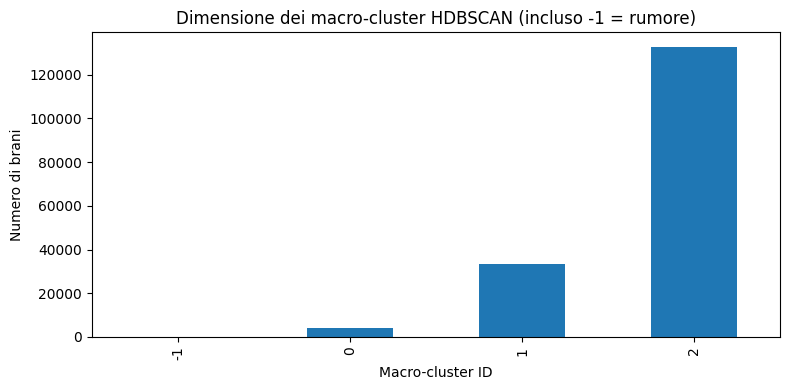

In [7]:
plt.figure(figsize=(8,4))
cluster_counts.plot(kind="bar")
plt.title("Dimensione dei macro-cluster HDBSCAN (incluso -1 = rumore)")
plt.xlabel("Macro-cluster ID")
plt.ylabel("Numero di brani")
plt.tight_layout()
plt.show()

# Cell 8 - UMAP 2D with macro-clusters colorized

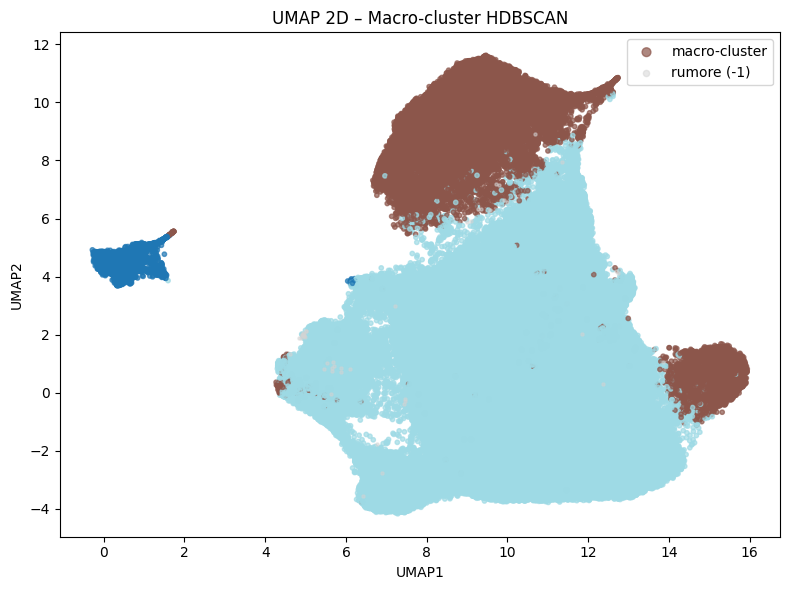

In [8]:
plt.figure(figsize=(8,6))

mask_noise = df_feat["macro_cluster"] == -1
mask_cluster = ~mask_noise

# Punti assegnati a cluster
plt.scatter(
    X_umap_2d[mask_cluster, 0],
    X_umap_2d[mask_cluster, 1],
    c=df_feat.loc[mask_cluster, "macro_cluster"],
    cmap="tab20",
    s=10,
    alpha=0.7,
    label="macro-cluster"
)

# Eventuale rumore
if mask_noise.any():
    plt.scatter(
        X_umap_2d[mask_noise, 0],
        X_umap_2d[mask_noise, 1],
        c="lightgray",
        s=5,
        alpha=0.5,
        label="rumore (-1)"
    )

plt.title("UMAP 2D – Macro-cluster HDBSCAN")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(markerscale=2)
plt.tight_layout()
plt.show()

# Cell 9 - Summary for the macro-cluster's label identification

In [9]:
valid_macro = df_feat["macro_cluster"] >= 0

macro_summary = (
    df_feat[valid_macro]
    .groupby("macro_cluster")[feature_cols]
    .mean()
    .sort_index()
)

macro_summary

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms
macro_cluster,,,,,,,,,,
0,0.466890,0.670988,0.256347,0.005135,0.330335,-18.668070,0.914562,107.570375,0.544091,180430.232198
1,0.735996,0.446744,0.341326,0.753779,0.186504,-15.765340,0.060999,110.350827,0.437707,259351.516248
2,0.432971,0.557255,0.532390,0.018023,0.208072,-10.052836,0.078384,118.878143,0.555503,225833.422273


# Cell 10 - Features' heatmap per macro-cluster

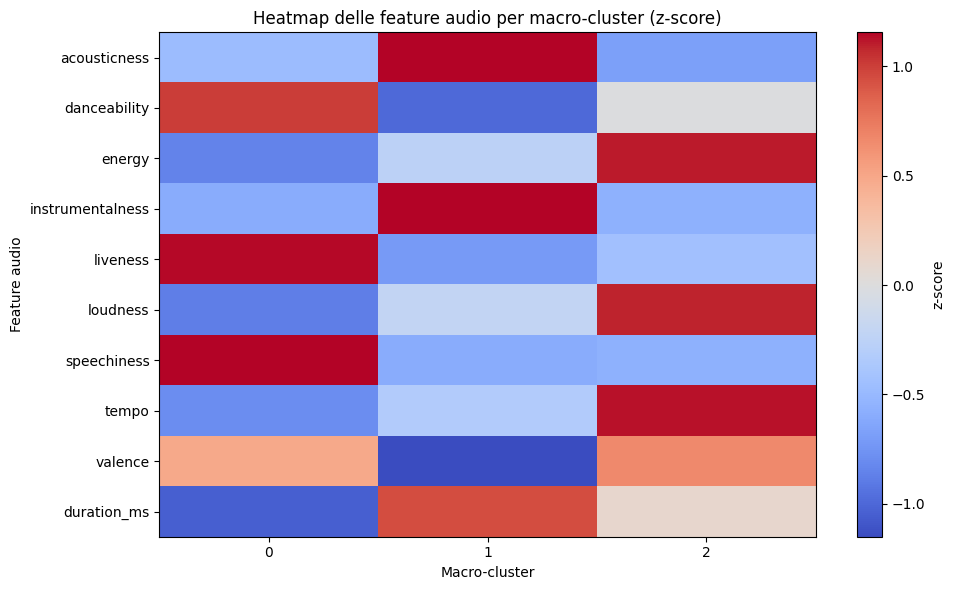

In [10]:
macro_summary_norm = (
    (macro_summary - macro_summary.mean()) / macro_summary.std()
)

plt.figure(figsize=(10,6))
im = plt.imshow(macro_summary_norm.T, aspect="auto", cmap="coolwarm")

plt.colorbar(im, label="z-score")

plt.yticks(
    ticks=range(len(macro_summary_norm.columns)),
    labels=macro_summary_norm.columns
)
plt.xticks(
    ticks=range(len(macro_summary_norm.index)),
    labels=macro_summary_norm.index
)

plt.title("Heatmap delle feature audio per macro-cluster (z-score)")
plt.xlabel("Macro-cluster")
plt.ylabel("Feature audio")
plt.tight_layout()
plt.show()


# Cell 11 - Gerarchic subclustering (K-means for every macro-cluster)

In [11]:
df_feat["subcluster"] = None  # conterrà stringhe tipo "0_0", "0_1", "1_0", ...

unique_macro = sorted([c for c in df_feat["macro_cluster"].unique() if c >= 0])
print("Macro-cluster su cui facciamo subclustering:", unique_macro)

subcluster_ids = []

for c in unique_macro:
    mask_c = df_feat["macro_cluster"] == c
    X_c = X_umap_10[mask_c]
    n_c = X_c.shape[0]
    print(f"\nMacro-cluster {c}: {n_c} brani")

    if n_c < 100:
        print("  Troppo pochi brani, salto il subclustering.")
        continue

    # Heuristica per numero di subcluster dentro c
    if n_c < 5000:
        k_c = 2
    elif n_c < 35000:
        k_c = 3
    else:
        k_c = 6

    print(f"  Uso KMeans con k = {k_c} subcluster")

    kmeans_c = KMeans(
        n_clusters=k_c,
        random_state=42,
        n_init=20
    )
    labels_c = kmeans_c.fit_predict(X_c)

    # Codifichiamo i subcluster come "macro_sub" (stringa)
    global_ids = [f"{c}_{l}" for l in labels_c]
    df_feat.loc[mask_c, "subcluster"] = global_ids

    subcluster_ids.extend(sorted(set(global_ids)))

print("\nSubcluster globali creati:", sorted(set(subcluster_ids)))


Macro-cluster su cui facciamo subclustering: [np.int64(0), np.int64(1), np.int64(2)]

Macro-cluster 0: 3876 brani
  Uso KMeans con k = 2 subcluster

Macro-cluster 1: 33296 brani
  Uso KMeans con k = 3 subcluster

Macro-cluster 2: 132689 brani
  Uso KMeans con k = 6 subcluster

Subcluster globali creati: ['0_0', '0_1', '1_0', '1_1', '1_2', '2_0', '2_1', '2_2', '2_3', '2_4', '2_5']


# Cell 12 - Summary for sub-clusters

In [12]:
df_sub = df_feat[df_feat["subcluster"].notna()].copy()

subcluster_summary = (
    df_sub
    .groupby("subcluster")[feature_cols]
    .mean()
    .sort_index()
)

subcluster_summary

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms
subcluster,,,,,,,,,,
0_0,0.716019,0.629867,0.356467,0.010616,0.437856,-17.629630,0.909939,101.782432,0.488521,316349.690217
0_1,0.342904,0.691453,0.206520,0.002407,0.276824,-19.184882,0.916863,110.450928,0.571748,112785.617852
1_0,0.123706,0.532323,0.705227,0.677175,0.194811,-9.505005,0.058397,123.643456,0.556363,262416.195078
1_1,0.901362,0.543261,0.330788,0.746927,0.201617,-14.191626,0.075448,117.138384,0.642267,187630.413734
1_2,0.905469,0.309065,0.156994,0.801226,0.167665,-20.608747,0.048622,96.783122,0.179411,326055.324619
2_0,0.197679,0.710954,0.667639,0.009789,0.150925,-8.080222,0.098626,111.071655,0.731749,228065.046605
2_1,0.866579,0.406590,0.196642,0.024769,0.163701,-15.532526,0.044766,96.971232,0.286622,209624.717744
2_2,0.499933,0.481602,0.420765,0.020217,0.152617,-11.099176,0.047563,132.237619,0.416631,267566.480063
2_3,0.430529,0.502923,0.602430,0.030016,0.718699,-9.926860,0.101822,118.542133,0.546908,254909.472375


# Cell 13 - Subclusters heatmap

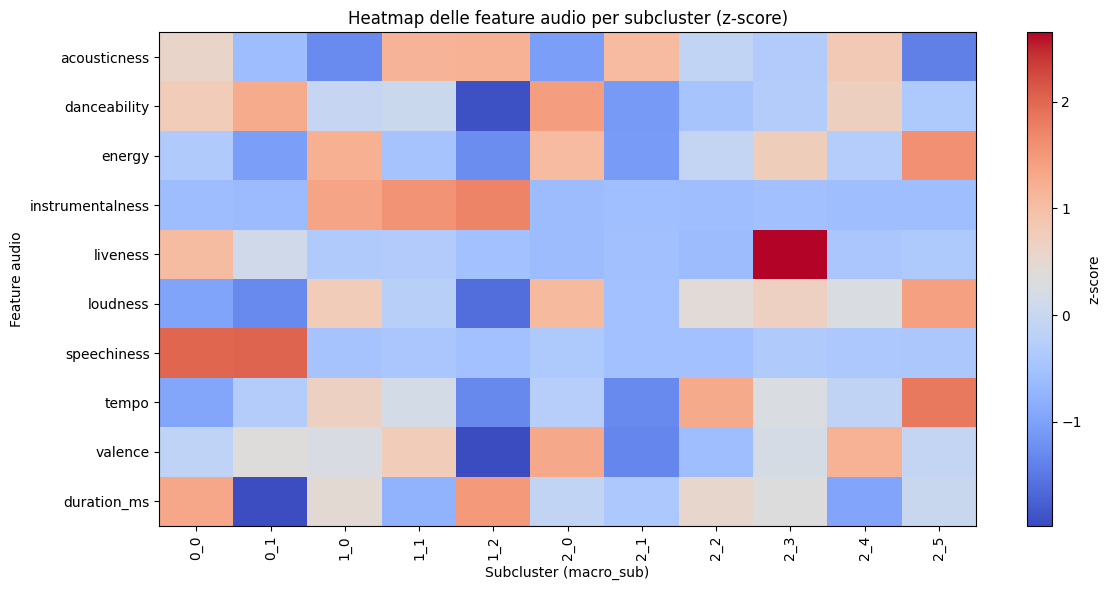

In [13]:
subcluster_summary_norm = (
    (subcluster_summary - subcluster_summary.mean()) / subcluster_summary.std()
)

plt.figure(figsize=(12,6))
im = plt.imshow(subcluster_summary_norm.T, aspect="auto", cmap="coolwarm")

plt.colorbar(im, label="z-score")

plt.yticks(
    ticks=range(len(subcluster_summary_norm.columns)),
    labels=subcluster_summary_norm.columns
)
plt.xticks(
    ticks=range(len(subcluster_summary_norm.index)),
    labels=subcluster_summary_norm.index,
    rotation=90
)

plt.title("Heatmap delle feature audio per subcluster (z-score)")
plt.xlabel("Subcluster (macro_sub)")
plt.ylabel("Feature audio")
plt.tight_layout()
plt.show()

# Cell 14 - UMAP 2D with colorized subclusters

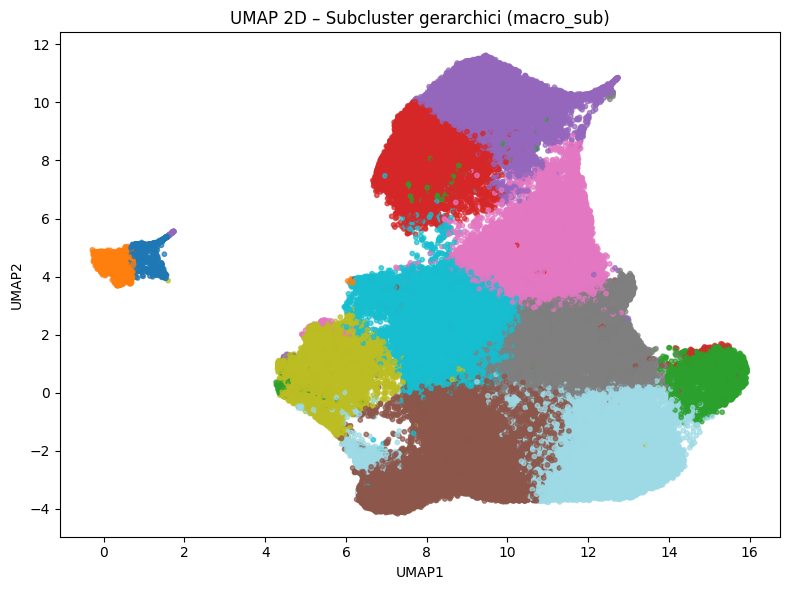

In [14]:
plt.figure(figsize=(8,6))

mask_sub = df_feat["subcluster"].notna()
sub_ids = df_feat.loc[mask_sub, "subcluster"]

# Mappiamo ogni subcluster stringa in un intero per il colore
sub_unique = sorted(sub_ids.unique())
sub_to_int = {s: i for i, s in enumerate(sub_unique)}
sub_int = sub_ids.map(sub_to_int).values

plt.scatter(
    X_umap_2d[mask_sub, 0],
    X_umap_2d[mask_sub, 1],
    c=sub_int,
    cmap="tab20",
    s=10,
    alpha=0.7
)

plt.title("UMAP 2D – Subcluster gerarchici (macro_sub)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


#  Cell 15 - Merging with orginal DF & saving

In [15]:
df_clustered = df.copy()

df_clustered = df_clustered.join(
    df_feat[["macro_cluster", "subcluster"]],
    how="left"
)
# === Dizionario di etichette interpretative per ciascun subcluster ===

SUBCLUSTER_LABELS = {
    # Macro 0 – spoken moods
    "0_0": "Short Spoken Calm",
    "0_1": "Long Spoken Emotional",

    # Macro 1 – calm ↔ epic moods
    "1_0": "Deep Calm & Minimal",
    "1_1": "Warm Emotional Calm",
    "1_2": "Epic Intense",

    # Macro 2 – pop/electronic mood spectrum
    "2_0": "Uplifting Gentle",
    "2_1": "Intense High-Energy",
    "2_2": "Happy Energetic",
    "2_3": "Soft Sad Calm",
    "2_4": "Balanced Upbeat",
    "2_5": "Energetic Live Mood"
}

df_clustered["subcluster_label"] = df_clustered["subcluster"].map(SUBCLUSTER_LABELS)
print("✔ Mood labels assegnate.")


✔ Mood labels assegnate.


In [17]:

print("Shape df_clustered:", df_clustered.shape)
df_clustered[["macro_cluster", "subcluster"]].head()
out_path = os.path.join(DATA_PROCESSED_DIR, "spotify_dataset_clustered.csv")
df_clustered.to_csv(out_path, index=False)
print("Salvato:", out_path)

Shape df_clustered: (169909, 18)
Salvato: ../data/processed/spotify_dataset_clustered.csv
